## Import Library

In [3]:
from google.colab import files
import io
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

## Read Input from File

In [4]:
uploaded = files.upload()

Saving traintest.xlsx to traintest.xlsx


### Train Data

In [5]:
dfTrain = pd.read_excel(io.BytesIO(uploaded['traintest.xlsx']), sheet_name='train', usecols=[1, 2, 3, 4])
dfTrain

,x1,x2,x3,y
0,60,64,0,1
1,54,60,11,0
2,65,62,22,0
3,34,60,0,1
4,38,69,21,0
...,...,...,...,...
291,59,64,1,1
292,65,67,0,1
293,53,65,12,0
294,57,64,1,0


1    218
0     78
Name: y, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


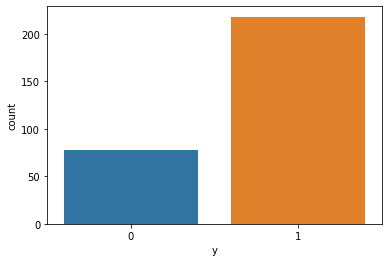

In [6]:
print(dfTrain['y'].value_counts())
sns.countplot(dfTrain['y'])
plt.show()

#### Imbalance Data

In [7]:
class0 = dfTrain[dfTrain['y'] == 0]
class0Over = class0.sample(218, replace=True, random_state=42)
dfTrain = pd.concat([dfTrain[dfTrain['y'] == 1], class0Over])

1    218
0    218
Name: y, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


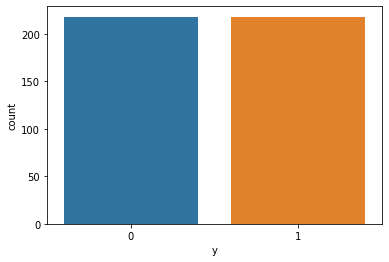

In [8]:
print(dfTrain['y'].value_counts())
sns.countplot(dfTrain['y'])
plt.show()

In [9]:
# shuffle
dfTrain = dfTrain.sample(frac=1, random_state=42)
dfTrain = dfTrain.reset_index()
dfTrain.drop('index', inplace=True, axis=1)
dfTrain

,x1,x2,x3,y
0,54,60,11,0
1,69,65,0,1
2,60,59,17,0
3,53,58,4,0
4,51,59,13,0
...,...,...,...,...
431,39,63,4,1
432,70,68,0,1
433,62,59,13,0
434,57,62,14,0


### Test Data

In [10]:
dfTest = pd.read_excel(io.BytesIO(uploaded['traintest.xlsx']), sheet_name='test', usecols=[1, 2, 3])
dfTest

,x1,x2,x3
0,43,59,2
1,67,66,0
2,58,60,3
3,49,63,3
4,45,60,0
5,54,58,1
6,56,66,3
7,42,69,1
8,50,59,2
9,59,60,0


## Proccess

### Training

#### L1 Distance (Manhattan Distance)
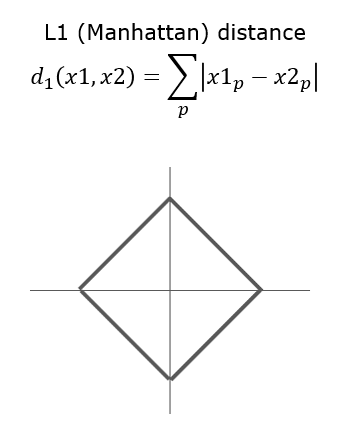

In [11]:
def L1(testData, trainData):
  sum = 0
  for i in range(0, 3):
    sum += abs(testData[i] - trainData[i])

  return sum

s1 = pd.Series({ 'x1':60, 'x2':64, 'x3':0 })
s2 = pd.Series({ 'x1':59, 'x2':64, 'x3':1 })
print(s1)
print(s2)
L1(s1, s2)

x1    60
x2    64
x3     0
dtype: int64
x1    59
x2    64
x3     1
dtype: int64


2

#### L2 Distance (Euclidean Distance)
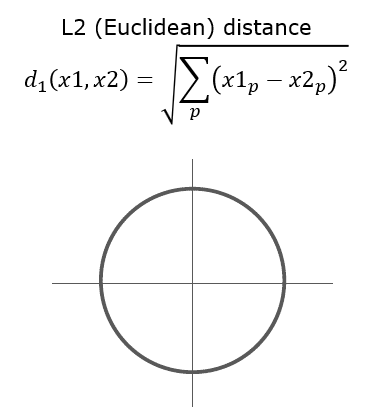

In [12]:
def L2(testData, trainData):
  sum = 0
  for i in range(0, 3):
    sum += (testData[i] - trainData[i])**2

  return math.sqrt(sum)

s1 = pd.Series({ 'x1':60, 'x2':64, 'x3':0 })
s2 = pd.Series({ 'x1':59, 'x2':64, 'x3':1 })
print(s1)
print(s2)
L2(s1, s2)

x1    60
x2    64
x3     0
dtype: int64
x1    59
x2    64
x3     1
dtype: int64


1.4142135623730951

#### Most Frequent Neighbor in k Neighbor

In [13]:
def mostFreqNeigh(distResult, k):
  # sort
  # print(distResult)
  distResult.sort(key=lambda row: (row[0]))
  # print(distResult)
  # find most frequent neighbor in k neighbor
  countClass0 = 0
  countClass1 = 0
  topK = distResult[0:k]
  for top in topK:
    if top[1] == 0:
      countClass0 += 1
    else:
      countClass1 += 1
  
  # print(countClass0, countClass1)
  if countClass0 > countClass1:
    return 0
  elif countClass1 > countClass0:
    return 1

### Hyperparameter Observation

#### Split Train Data

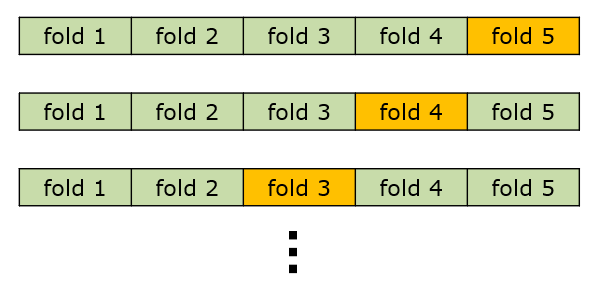

In [14]:
# use 5-fold
# 80% train data, 20% validation data

# normal
# dfFold1 = dfTrain[0:60]
# dfFold2 = dfTrain[60:119]
# dfFold3 = dfTrain[119:178]
# dfFold4 = dfTrain[178:237]
# dfFold5 = dfTrain[237:296]

# oversampling
dfFold1 = dfTrain[0:88]
dfFold2 = dfTrain[88:175]
dfFold3 = dfTrain[175:262]
dfFold4 = dfTrain[262:349]
dfFold5 = dfTrain[349:436]

len(dfTrain)

436

#### Define Train Data and Validation Data

In [15]:
# train data and validation data
def makeTrainAndVal(foldForValidation):
  # new train data
  trainSplit = [dfFold1, dfFold2, dfFold3, dfFold4, dfFold5]
  val = trainSplit.pop(foldForValidation - 1)
  dfTrainSplit = pd.concat(trainSplit)

  # validation data
  dfVal = val.copy()

  return dfTrainSplit, dfVal

#### Evaluation Model

In [16]:
def evalModel(pred, actual):
  TP, FN, TN, FP = 0, 0, 0, 0
  for idx in range(len(pred)):
    if pred[idx] == actual.values[idx]:
      if pred[idx] == 0:
        TN += 1
      else:
        TP += 1
    else:
      if pred[idx] == 0:
        FN += 1
      else:
        FP += 1
  
  return TP, FN, TN, FP

#### Find Best Hyperparameter (k)

In [17]:
maxK = 52
avgTabKL1 = [0 for x in range(0, maxK)]
avgTabKL2 = [0 for x in range(0, maxK)]

for foldForValidation in range(5, 0, -1):
  # set i-th portion as validation data
  dfTrainSplit, dfVal = makeTrainAndVal(foldForValidation)
  print('> fold', foldForValidation, 'as a validation: ...')

  # select hyperparameter
  tabKL1 = [0 for x in range(0, maxK)]
  tabKL2 = [0 for x in range(0, maxK)]
  # use piegon hole principle --> class + 1
  for k in range(1, maxK, 2): # 1 .. 3 .. 5 .. 7 ..
    # test model on validation data
    tabPredValL1 = []
    tabPredValL2 = []
    for val in range(len(dfVal)):
      tabL1Score = []
      tabL2Score = []
      dfCurrVal = dfVal.iloc[val] # return Series
      # print(dfCurrVal)
      for train in range(len(dfTrainSplit)):
        dfCurrTrain = dfTrainSplit.iloc[train] # return Series
        # print(dfCurrTrain)

        # save L2 score validation data
        L1Score = L1(dfCurrVal, dfCurrTrain)
        L2Score = L2(dfCurrVal, dfCurrTrain)
        tabL1Score.append([L1Score, dfCurrTrain[3]])
        tabL2Score.append([L2Score, dfCurrTrain[3]])
      
      # predict class of validation data
      predClassL1 = mostFreqNeigh(tabL1Score, k)
      predClassL2 = mostFreqNeigh(tabL2Score, k)
      # print(predClass)
      tabPredValL1.append(predClassL1)
      tabPredValL2.append(predClassL2)

    # print(tabPredVal)
    # evaluation model with hyperparameter k
    TP1, FN1, TN1, FP1 = evalModel(tabPredValL1, dfVal['y'])
    TP2, FN2, TN2, FP2 = evalModel(tabPredValL2, dfVal['y'])

    # confussion matrix
    # confMat = [[TP, FP], [FN, TN]]
    # print(confMat)
    # recall
    recall1 = TP1 / (TP1 + FN1)
    recall2 = TP2 / (TP2 + FN2)
    # print(recall)
    # precision
    precision1 = TP1 / (TP1 + FP1)
    precision2 = TP2 / (TP2 + FP2)
    # print(precision)
    # f1-score
    f1Score1 = 2 * precision1 * recall1 / (precision1 + recall1)
    f1Score2 = 2 * precision2 * recall2 / (precision2 + recall2)
    # print(f1Score)
    # accuracy
    accuracy1 = (TP1 + TN1) / (TP1 + FN1 + TN1 + FP1)
    accuracy2 = (TP2 + TN2) / (TP2 + FN2 + TN2 + FP2)
    # save f1-score based on hyperparameter k
    tabKL1[k] = f1Score1
    # tabKL1[k] = precision1
    # tabKL1[k] = recall1 # recall score so high --> make f1 high too
    # tabKL1[k] = accuracy1
    tabKL2[k] = f1Score2
    # tabKL2[k] = precision2
    # tabKL2[k] = recall2
    # tabKL2[k] = accuracy2

  # average f1-score based on hyperparameter k
  print('tab k for L1 (f1-score):')
  print(tabKL1)
  print('tab k for L2 (f1-score):')
  print(tabKL2)
  print()
  for k in range(1, maxK, 2):
    avgTabKL1[k] += tabKL1[k]
    avgTabKL2[k] += tabKL2[k]


for k in range(1, maxK, 2):
  avgTabKL1[k] /= 5
  avgTabKL2[k] /= 5

print('avgTabK L1:')
print(avgTabKL1)
print('avgTabK L2:')
print(avgTabKL2)

> fold 5 as a validation: ...
tab k for L1 (f1-score):
[0, 0.7951807228915662, 0, 0.7764705882352941, 0, 0.7692307692307693, 0, 0.7341772151898734, 0, 0.735632183908046, 0, 0.6966292134831461, 0, 0.7045454545454545, 0, 0.7333333333333334, 0, 0.7191011235955057, 0, 0.7526881720430109, 0, 0.7311827956989247, 0, 0.711111111111111, 0, 0.7555555555555555, 0, 0.7555555555555555, 0, 0.7764705882352941, 0, 0.7499999999999999, 0, 0.7415730337078652, 0, 0.7311827956989247, 0, 0.7446808510638299, 0, 0.7391304347826086, 0, 0.7526881720430109, 0, 0.7446808510638299, 0, 0.7446808510638299, 0, 0.74, 0, 0.7272727272727273, 0, 0.693069306930693]
tab k for L2 (f1-score):
[0, 0.8, 0, 0.7857142857142858, 0, 0.7466666666666667, 0, 0.6933333333333334, 0, 0.6582278481012659, 0, 0.627906976744186, 0, 0.7000000000000001, 0, 0.7380952380952381, 0, 0.7586206896551724, 0, 0.7954545454545455, 0, 0.7333333333333334, 0, 0.7333333333333334, 0, 0.7415730337078652, 0, 0.7126436781609196, 0, 0.6976744186046512, 0, 0.688

#### Visualize Average Validation Performance (f1 Score)

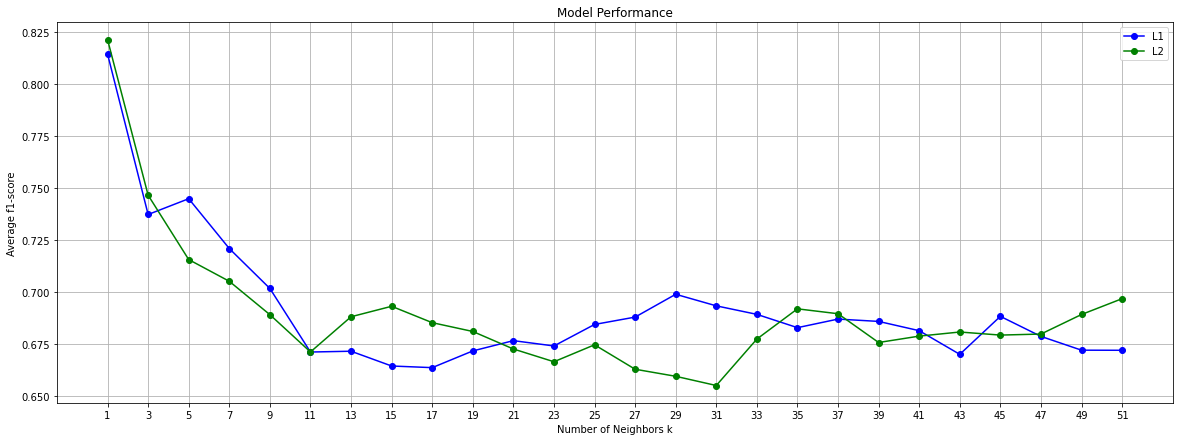

In [18]:
listK = [x for x in range(1, maxK, 2)]
avg1 = avgTabKL1.copy()
avg2 = avgTabKL2.copy()
idx = 0
while idx < len(avg1):
  avg1.pop(idx)
  avg2.pop(idx)
  idx += 1

plt.figure(figsize=(20, 7))
plt.plot(listK, avg1, marker='o', color='blue', label='L1')
plt.plot(listK, avg2, marker='o', color='green', label='L2')
plt.title('Model Performance')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Average f1-score')
plt.grid(True)
plt.xticks(listK)
plt.legend()
plt.show()

#### Get Best Hyperparameter (k)

In [19]:
bestKL1 = avgTabKL1.index(max(avgTabKL1))
bestKL2 = avgTabKL2.index(max(avgTabKL2))
print('> L1:')
print('k:', bestKL1)
print('average f1-score:', avgTabKL1[bestKL1])
print('> L2:')
print('k:', bestKL2)
print('average f1-score:', avgTabKL2[bestKL2])

bestK = 0
distL = ''
if avgTabKL1[bestKL1] > avgTabKL2[bestKL2]:
  bestK = bestKL1
  distL = 'L1'
else:
  bestK = bestKL2
  distL = 'L2'

print('> best hyperparameter:')
print('k:', bestK)
print('distance:', distL)

> L1:
k: 1
average f1-score: 0.8143318920280423
> L2:
k: 1
average f1-score: 0.8213002228025909
> best hyperparameter:
k: 1
distance: L2


### Final Model

In [20]:
# use best k
# function for model
  # output: y label

def finalModel(dataTest, bestK, distL):
  tabPredTest = []
  for test in range(len(dataTest)):
    tabLScore = []
    dfCurrTest = dataTest.iloc[test]
    for train in range(len(dfTrain)):
      dfCurrTrain = dfTrain.iloc[train]
      # save L score test data
      if distL == 'L1':
        LScore = L1(dfCurrTest, dfCurrTrain)
      elif distL == 'L2':
        LScore = L2(dfCurrTest, dfCurrTrain)

      tabLScore.append([LScore, dfCurrTrain[3]])
    
    # predict class of test data
    predClass = mostFreqNeigh(tabLScore, bestK)
    # print(predClass)
    tabPredTest.append(predClass)
  
  return tabPredTest

### Test Model on Test Data

In [21]:
finalModel(dfTest, bestK, distL)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

In [22]:
yPred = finalModel(dfTest, bestK, distL)
id = [x for x in range(297, 307)]
output = dfTest.copy()
output.insert(0, 'id', id)
output['y'] = yPred
output

,id,x1,x2,x3,y
0,297,43,59,2,1
1,298,67,66,0,1
2,299,58,60,3,1
3,300,49,63,3,1
4,301,45,60,0,1
5,302,54,58,1,1
6,303,56,66,3,1
7,304,42,69,1,0
8,305,50,59,2,1
9,306,59,60,0,1


### Save Output to Excel File

In [23]:
output.to_excel('output.xlsx', index=False)